# 多图协作

编译 langgraph 实例会将其转换为常规的可运行的 langchain。 这可以用作任何其他图中的节点。

创建子图可以让您构建诸如多代理团队之类的东西，其中每个团队都可以跟踪自己单独的状态。

下面是一个简单的（有点做作的）图示例，其中一个节点本身就是一个图。 该子图将包含一个简单的无工具“代理”，它生成响应，然后循环自我不断改进

In [ ]:
%pip install -U langgraph langchain_anthropic

In [ ]:
import getpass
import os

os.environ["LANGCHAIN_API_KEY"] = getpass.getpass("LANGCHAIN_API_KEY")
os.environ["ANTHROPIC_API_KEY"] = getpass.getpass("ANTHROPIC_API_KEY")

In [1]:
from langchain_openai import ChatOpenAI, OpenAI

openai_api_key = "EMPTY"
openai_api_base = "http://127.0.0.1:1234/v1"
# llm = ChatOpenAI(
#     openai_api_key=openai_api_key,
#     openai_api_base=openai_api_base,
#     temperature=0.3,
#     model_kwargs = {
#         "frequency_penalty":0.9,
#         "presence_penalty":0.9
#     }
# )
llm = ChatOpenAI(
    openai_api_key=openai_api_key,
    openai_api_base=openai_api_base,
    temperature=0.3,
)

## Subgraph

我们的玩具子图将是一个简单的循环，它生成一个笑话，然后自我批评。

In [57]:
import operator
from typing import Annotated, List, TypedDict

# from langchain_anthropic import ChatAnthropic
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

from langgraph.graph import END, StateGraph
from langchain_core.messages import SystemMessage,HumanMessage,AIMessage

# llm = ChatAnthropic(temperature=0, model_name="claude-3-opus-20240229")
prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "你就是那个爱开玩笑的人。 用一个笑话来回应，这是有史以来最好的笑话。",
        ),
        MessagesPlaceholder(variable_name="messages"),
    ],
)


critic_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", """{message}
-------
请提出对这个笑话的改进建议，使其成为有史以来最好的笑话。"""),
    ],
)


def update(out):
    return {"messages": [("assistant",out.content)]}


def replace_role(out):
    print("replace_role--------")
    print(out)
    print("replace_role_end--------")
    return {"messages": [HumanMessage(out.content)]}

def critiqueFn(state):
    print("state---------------------")
    print(state)
    message = state["messages"][-1]
    print(message)
    print("state end---------------------")
    return {"message":message[1]}

In [58]:
## 构建子图


class SubGraphState(TypedDict):
    messages: Annotated[List, operator.add]


builder = StateGraph(SubGraphState)
builder.add_node("tell_joke", prompt | llm | update)
builder.add_node("critique", critiqueFn |critic_prompt | llm | replace_role)


def route(state):
    return END if len(state["messages"]) >= 3 else "critique"


builder.add_conditional_edges("tell_joke", route)
builder.add_edge("critique", "tell_joke")
builder.set_entry_point("tell_joke")
joke_graph = builder.compile()

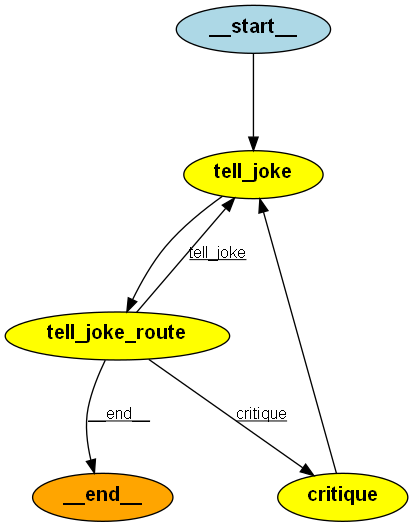

In [59]:
from IPython.display import Image

Image(joke_graph.get_graph().draw_png())

In [60]:
for step in joke_graph.stream({"messages": [("user", "讲一个关于减肥的笑话")]}):
    print(step)

{'tell_joke': {'messages': [('assistant', '为什么减肥就像骑自行车呢？因为一旦你停下来，你就得重新开始！')]}}
state---------------------
{'messages': [('user', '讲一个关于减肥的笑话'), ('assistant', '为什么减肥就像骑自行车呢？因为一旦你停下来，你就得重新开始！')]}
('assistant', '为什么减肥就像骑自行车呢？因为一旦你停下来，你就得重新开始！')
state end---------------------
replace_role--------
content='这个笑话本身已经具有幽默感了，但为了让它更加有趣和令人印象深刻，我们可以考虑以下改进建议：\n\n1. 增加细节描述：在笑话中加入一些关于骑自行车或减肥的具体场景或细节，让读者更容易产生共鸣。例如，可以描述一个人在骑自行车时突然停下来，然后看着自己发胖的身体，意识到需要重新开始减肥。\n2. 运用比喻：将减肥比作其他更具有挑战性和困难的事情，以增加幽默感。例如，可以将减肥比作攀登珠穆朗玛峰，一旦你停下脚步，你就得从头再来。\n3. 加入反转或意外元素：在笑话中加入一个意想不到的转折点，让读者感到惊喜和愉悦。例如，一个人努力减肥后终于成功了，但当他骑自行车时却因为太瘦而无法保持平衡，不得不重新开始增重。' response_metadata={'token_usage': {'completion_tokens': 184, 'prompt_tokens': 184, 'total_tokens': 368}, 'model_name': 'gpt-3.5-turbo', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}
replace_role_end--------
{'critique': {'messages': [HumanMessage(content='这个笑话本身已经具有幽默感了，但为了让它更加有趣和令人印象深刻，我们可以考虑以下改进建议：\n\n1. 增加细节描述：在笑话中加入一些关于骑自行车或减肥的具体场景或细节，让读者更容易产生共鸣。例如，可以描述一个人在骑自行

## Main Graph

主图只是一个路由器，它将消息发送到笑话图或直接响应。

In [83]:
from langchain_core.output_parsers import StrOutputParser
output_parser = StrOutputParser()

class AssistantState(TypedDict):
    conversation: Annotated[List, operator.add]


# assistant_llm = ChatAnthropic(temperature=0, model_name="claude-3-opus-20240229")
assistant_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", "你是一个得力的助手"),
        MessagesPlaceholder(variable_name="conversation"),
    ]
)


def add_to_conversation(message):
    return {"conversation": [message]}


main_builder = StateGraph(AssistantState)
main_builder.add_node(
    "assistant", assistant_prompt | llm | add_to_conversation
)


def get_user_message(state: AssistantState):
    last_message = state["conversation"][-1]
    # Convert to sub-graph state
    return {"messages": [last_message]}


def get_joke(state: SubGraphState):
    final_joke = state["messages"][-1]
    return {"conversation": [final_joke]}


main_builder.add_node("joke_graph", get_user_message | joke_graph | get_joke)


def route(state: AssistantState):
    message = state["conversation"][-1][-1]

    assistant_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", """你是一个意图识别的助手，能够识别以下意图：
1. 讲故事
2. 讲笑话
3. AI绘画
4. 学习知识
5. 其他

例如：
用户输入：给我说个故事把。
1
用户输入：给我画个美女图片。
3

------
用户输入：{input}

请识别用户意图，返回上面意图的数字序号，只返回数字，不返回任何其他字符。
""")
        ]
    )

    chain = assistant_prompt | llm | output_parser

    result = chain.invoke({
        "input":message
    })

    result = result.strip()

    print("意图识别：",result)

    if result=="2" :
        return "joke_graph"
    else :
        return "assistant"


main_builder.set_conditional_entry_point(
    route,
)
main_builder.set_finish_point("assistant")
main_builder.set_finish_point("joke_graph")
graph = main_builder.compile()

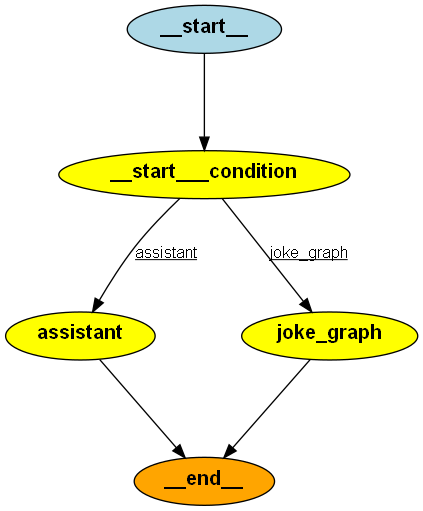

In [84]:
Image(graph.get_graph().draw_png())

In [85]:
for step in graph.stream({"conversation": [("user", "请给我讲个减肥笑话")]}):
    print(step)

意图识别： 2
state---------------------
{'messages': [('user', '请给我讲个减肥笑话'), ('assistant', '为什么减肥总是这么难？因为肉很顽固，它们不想离开你！')]}
('assistant', '为什么减肥总是这么难？因为肉很顽固，它们不想离开你！')
state end---------------------
replace_role--------
content='这个笑话本身已经很有趣了，但如果你想要让它更加出色，可以考虑以下几点：\n1. 增加一些细节或场景描述，让读者更容易想象到画面。例如："为什么减肥总是这么难？因为肉很顽固，它们不想离开你！就像你小时候最喜欢的玩具，紧紧抱住不放一样。"\n2. 加入双关语或其他语言技巧，增加笑话的趣味性。例如："为什么减肥总是这么难？因为肉很顽固，它们不想离开你！就像你最爱的零食，粘在手上就不想放手一样。"\n3. 改变叙述方式或视角，让读者感到新鲜和惊喜。例如："为什么减肥总是这么难？因为肉很顽固，它们不想离开你！这是一场人与食物的持久战，而这场战争中，我们往往都是输家。"' response_metadata={'token_usage': {'completion_tokens': 180, 'prompt_tokens': 180, 'total_tokens': 360}, 'model_name': 'gpt-3.5-turbo', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}
replace_role_end--------
{'joke_graph': {'conversation': [('assistant', '谢谢你的建议！让我再尝试一个改进版的笑话：\n\n为什么减肥总是这么难？因为肉很顽固，它们不想离开你！就像你最爱的零食，粘在手上就不想放手一样。但是，别担心，只要你有足够的决心和毅力，总有一天你会把它们甩掉的！')]}}
{'__end__': {'conversation': [('user', '请给我讲个减肥笑话'), ('assistant', '谢谢你的建议！让我再尝试一个改进版的笑话：\n\n为什么减肥总是这么

In [86]:
for step in graph.stream({"conversation": [("user", "推荐一点夏天的减肥餐")]}):
    print(step)

意图识别： 4
{'assistant': {'conversation': [AIMessage(content='夏天是减肥的好时机，因为天气炎热，人们更容易出汗和代谢。以下是一些适合夏季的减肥餐建议：\n\n1. 沙拉：沙拉是夏天最受欢迎的健康食品之一。你可以选择各种新鲜蔬菜、水果、瘦肉或海鲜作为配料，搭配低脂沙拉酱或橄榄油醋汁。例如，尝试黄瓜番茄沙拉、牛油果虾仁沙拉等。\n2. 烤鱼和蔬菜：将新鲜的鱼类（如鲈鱼、三文鱼）用香料腌制后，放入烤箱中烤制，再搭配一些新鲜蔬菜（如芦笋、西葫芦、胡萝卜）一起食用，既美味又健康。\n3. 鸡肉串配时蔬：将鸡胸肉切成小块，加入调料腌制后穿在竹签上，与各种蔬菜（如青椒、洋葱、蘑菇）一起烤制，既可以作为正餐也可以作为小吃。\n4. 水果酸奶冰沙：将新鲜的水果（如草莓、蓝莓、香蕉）和低脂酸奶混合在一起，再加入一些冰块打成冰沙，既清凉解暑又营养丰富。\n5. 清蒸海鲜配糙米饭：选择新鲜的虾、贝类或鱼类进行清蒸，搭配一碗糙米饭，既能满足你的味蕾又能提供足够的蛋白质和纤维素。\n6. 蔬菜汤：用各种新鲜蔬菜（如番茄、胡萝卜、芹菜）熬制一锅美味的蔬菜汤，既可以作为主食也可以作为配餐。\n7. 烤鸡胸肉配沙拉：将鸡胸肉切成小块，加入调料腌制后放入烤箱中烤制，再搭配一份新鲜的蔬菜沙拉，简单又健康。\n8. 蒸红薯和鸡蛋：将红薯去皮切块，与鸡蛋一起放入锅中蒸熟，既可以作为主食也可以作为配餐。\n9. 番茄意面：用新鲜番茄熬制成酱汁，拌入意大利面中，再加入一些橄榄油、盐和黑胡椒调味，简单又美味。\n10. 烤蔬菜拼盘：将各种蔬菜（如茄子、南瓜、青椒）切成小块，刷上少许橄榄油后放入烤箱中烤制，既可以作为主食也可以作为配餐。', response_metadata={'token_usage': {'completion_tokens': 487, 'prompt_tokens': 489, 'total_tokens': 976}, 'model_name': 'gpt-3.5-turbo', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None})]}}
{'__end__': {'conversation': [('user', '推荐一点夏天的减肥餐'),